# **Trabajo Práctico 2**





# **Aprendizaje Automático 2**

**Facultad de Ciencias Exactas, Ingeniería y Agrimensura - TUIA**

**Alumnos:**


*   Ferrero Santiago
*   Loza Santiago



----------------------------------------------------------------------------------------------------------------------------------------------------------------



Enunciado: https://docs.google.com/document/d/e/2PACX-1vRWZYM_U5JlyejIB1bMkTOl8V06tsh0OAYM21LVQCMg_AkjBcn2ATfF6jXgKA2qiUlgv7rqcu50QHQY/pub

## Preparación del entorno.

Importamos las librerias necesarias

In [1]:
!pip install pydub

In [2]:
import os
import pathlib
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow_datasets as tfds
from IPython import display
from sys import breakpointhook
from IPython.display import Audio, display
from tensorflow.keras.layers import TextVectorization
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

Establecer GPU por defecto en caso de estar disponible.

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Problema 1 - Audio MNIST

Descripción:


En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

Dataset:
https://www.tensorflow.org/datasets/catalog/spoken_digit


El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

Objetivo:


Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:

Modelo convolucional sobre los espectrogramas de los clips.
Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

## Descargar dataset:


In [125]:
# Cargamos el conjunto de datos y lo dividimos en entrenamiento (80%) y prueba (20%)
ds_train_split, ds_test_split, = tfds.load(
    'spoken_digit',
    batch_size=64,
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=False
)

# Contamos el numero de batches
num_train_examples = sum(1 for _ in ds_train_split)
num_test_examples = sum(1 for _ in ds_test_split)

# Mostramos
print('Número de batches de entrenamiento:', num_train_examples)
print('Número de batches de prueba:', num_test_examples)

Número de batches de entrenamiento: 32
Número de batches de prueba: 8


In [126]:
#Funcion que obtiene las clases unicas de un dataset
def get_classes(dataset):
    classes = set()
    for _, label in tfds.as_numpy(dataset):
      for i in label:
        classes.add(i)
    return classes

# Obtenemos las clases de train y test
train_classes = get_classes(ds_train_split)
test_classes = get_classes(ds_test_split)

labels_name = [i for i in train_classes]

# Mostramos
print('Clases en el conjunto de entrenamiento:', train_classes)
print('Clases en el conjunto de prueba:', test_classes)

Clases en el conjunto de entrenamiento: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Clases en el conjunto de prueba: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [127]:
for example_audio, example_labels in ds_train_split.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6457)
(64,)


In [128]:
ds_train_split.take(1).take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [129]:
for waveform, label in tfds.as_numpy(ds_train_split.take(1)):
  print(waveform, label)

[[   0    0 -256 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [ -10   -6  -25 ...  -26   -8  -14]
 ...
 [ 135  143   77 ...    0    0    0]
 [   0   -2    4 ...    0    0    0]
 [  16   14   33 ...    0    0    0]] [2 1 9 9 7 5 3 6 1 8 1 5 5 4 8 6 4 6 4 2 4 3 3 7 4 0 6 4 7 8 1 9 6 7 7 4 6
 8 3 2 4 5 8 2 9 9 2 9 9 1 5 2 6 7 5 8 1 0 9 1 8 9 8 0]


Visualizamos

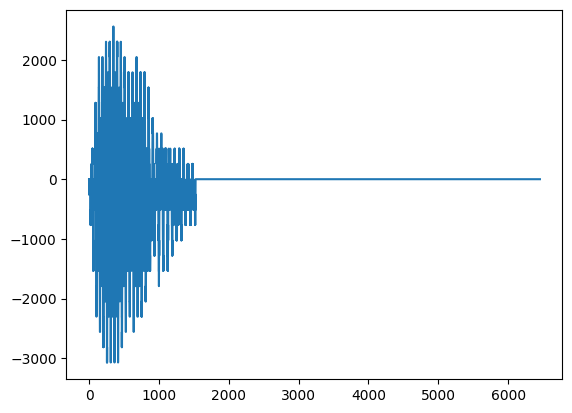

In [130]:
plt.plot(waveform[0])

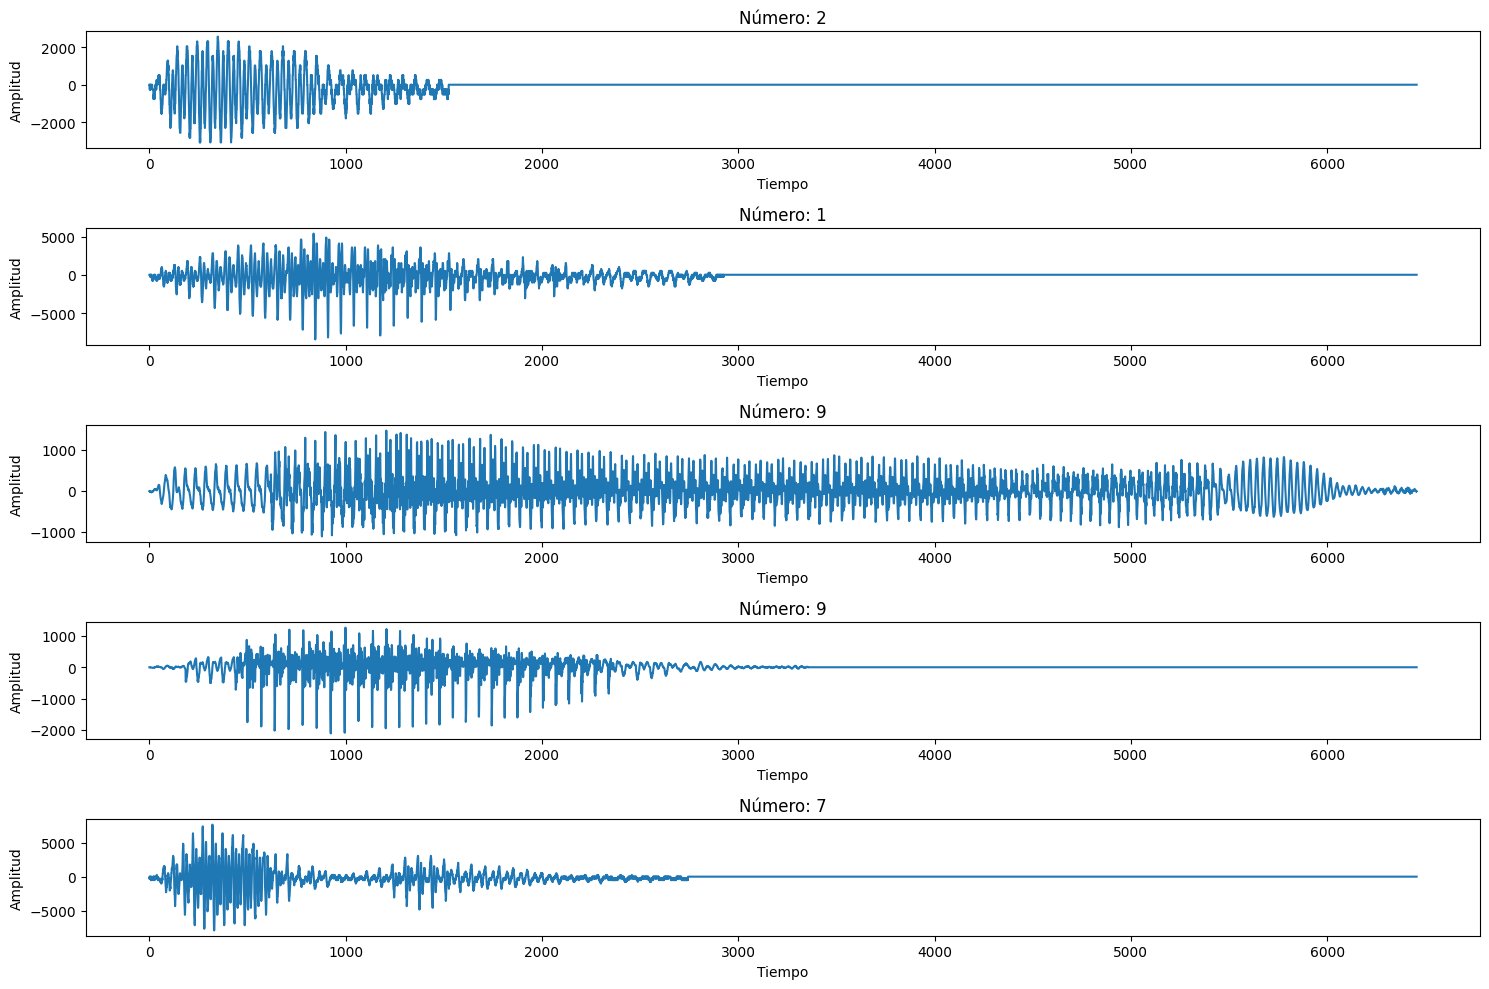

In [131]:
#Funcion que grafica las formas de onda de los primeros num_examples ejemplos en el dataset
def plot_waveforms(dataset, num_examples=5):
    plt.figure(figsize=(15, 10))
    for i, (waveform, label) in enumerate(tfds.as_numpy(dataset.take(1))):
      for n in range(num_examples):
        plt.subplot(num_examples, 1, n + 1)
        plt.plot(waveform[n])
        plt.title(f'Número: {label[n]}')
        plt.xlabel('Tiempo')
        plt.ylabel('Amplitud')
    plt.tight_layout()
    plt.show()

# Graficar formas de onda de algunos ejemplos del conjunto de entrenamiento
plot_waveforms(ds_train_split, num_examples=5)

Notamos que los audios tienen distintas duraciones

In [132]:
for example_audio, example_labels in ds_train_split.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 6457)
(64,)


## Convertir formas de onda a espectrogramas

Las formas de onda en el conjunto de datos están representadas en el dominio del tiempo. A continuación, se transforman las formas de onda de señales del dominio del tiempo a señales del dominio tiempo-frecuencia al calcular la transformada de Fourier de corto tiempo (STFT) para convertir las formas de onda en espectrogramas, que muestran cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D.


In [133]:
def get_spectrogram(waveform):
    # Convertir la forma de onda en un espectrograma a través de un STFT.
    spectrogram = tf.signal.stft(
        tf.cast(waveform, tf.float32), frame_length=255, frame_step=128)

    # Obtener la magnitud del STFT.
    spectrogram = tf.abs(spectrogram)

    # Agregar una dimensión `channels`, para que el espectrograma se pueda usar
    # como datos de entrada similares a una imagen con capas de convolución (que esperan
    # forma (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Imprimir las formas de uno de los ejemplos de la forma de onda tensorizada y el espectrograma correspondiente, y reproducir el audio original:

In [134]:
for i in range(3):
  label = labels_name[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display(Audio(waveform.numpy(), rate=8000))

Label: 2
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 1
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 9
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


## Función y ploteo de espectogramas

In [135]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Ploteamos formas de onda y sus respectivos espectrogramas.

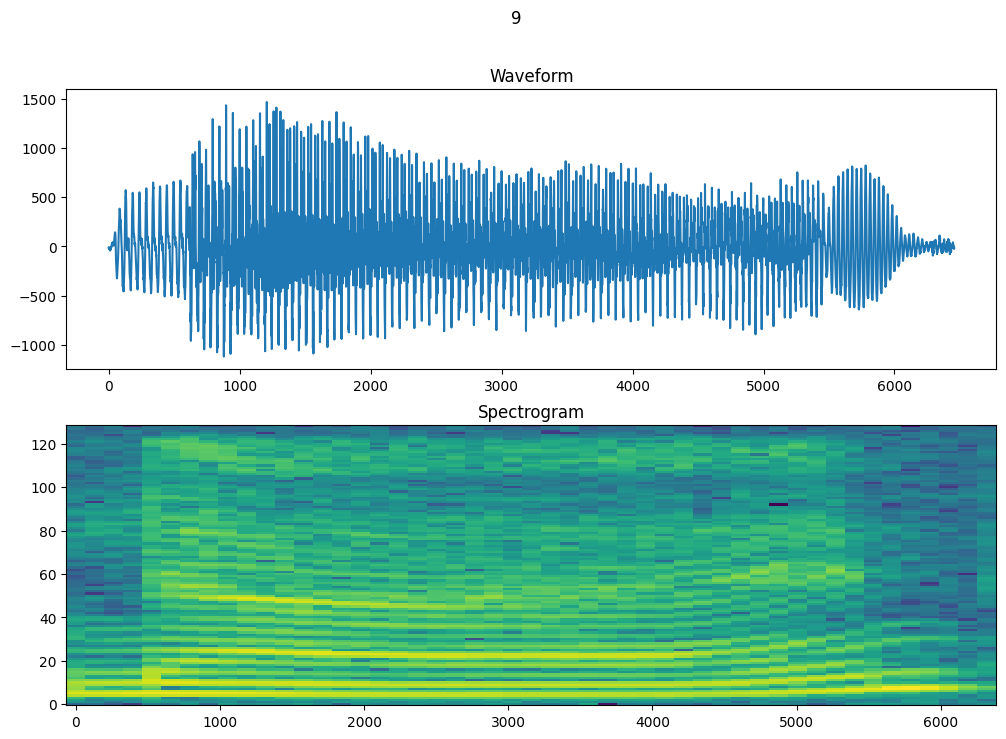

In [136]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')


plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(str(label).title())
plt.show()

Ahora creamos un dataset de espectrogramas utilizando la función definida.

In [137]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [138]:
train_spectrogram_ds = make_spec_ds(ds_train_split)
val_spectrogram_ds = make_spec_ds(ds_test_split)

Examinar el espectrograma para distintos ejemplos del dataset.

In [139]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [140]:
example_spectrograms.shape

TensorShape([64, 49, 129, 1])

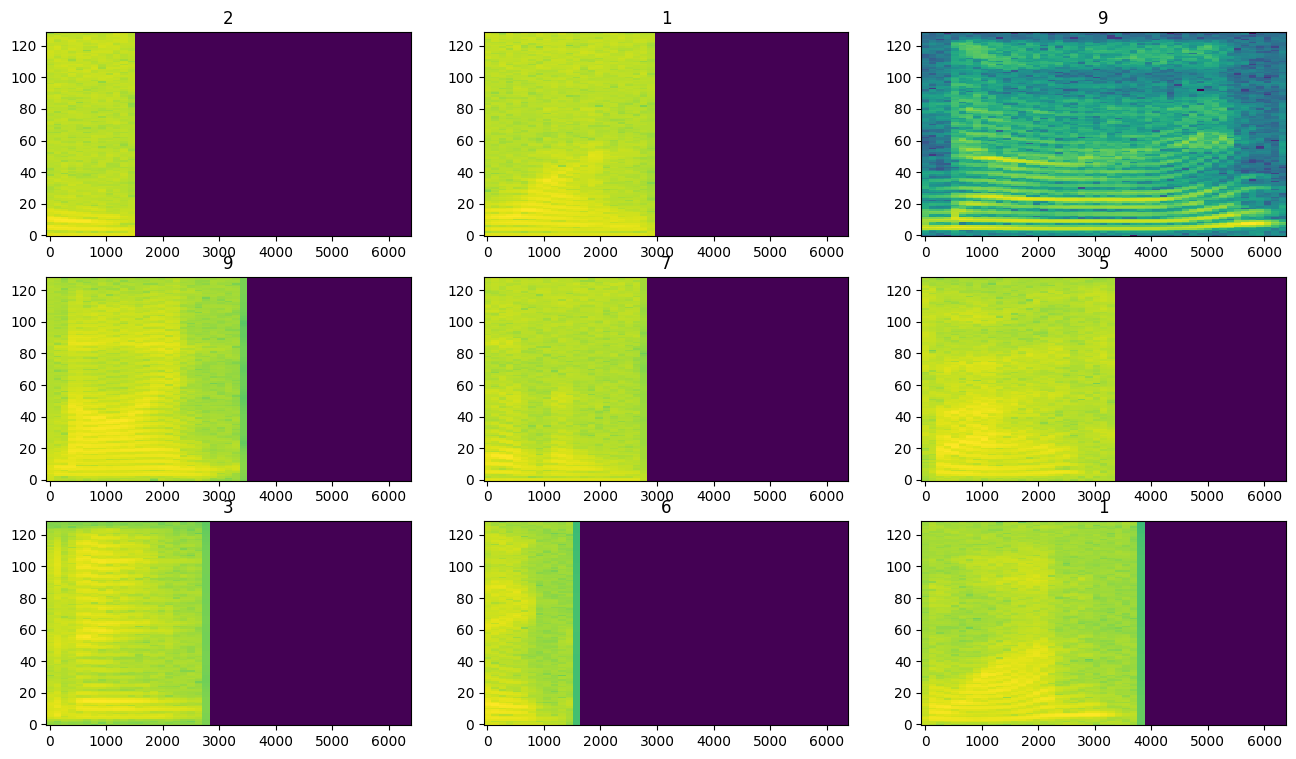

In [141]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(labels_name[example_spect_labels[i].numpy()])

plt.show()

Podemos observar que, debido a la diferencia en la duración de los audios, algunos segmentos no presentan ruido porque el audio se corta antes.

## Modelo convolucional


Optimizamos la carga del dataset

In [142]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Para el modelo, se utilizará una red neuronal convolucional simple (CNN), ya que se han transformado los archivos de audio en imágenes de espectrograma.


In [168]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_name)

# Normalizamos
norm_layer = layers.Normalization() # Normaliza cada pixel en la imagen basandose en su media y desvio estandar.

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec)) # Calcula las estadistincas agregadas (media y desvio estandar)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32), # Reduce la resolución d3e entrada y permite que el modelo entrene mas rapido
    norm_layer,

    layers.Conv2D(18, 3, activation='relu'),
    layers.Dropout(0.50),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.50),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])

model.summary()

Input shape: (49, 129, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_5 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 18)        180       
                                                                 
 dropout_12 (Dropout)        (None, 30, 30, 18)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        5216      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                        

Compilamos el modelo:

In [169]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos durante 50 epochs

In [170]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-2, mode="min"
)


EPOCHS = 200
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/200


32/32 [==============================] - 3s 27ms/step - loss: 1.7902 - accuracy: 0.3620 - val_loss: 1.6048 - val_accuracy: 0.5100 - lr: 0.0010
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 1.2165 - accuracy: 0.6120 - val_loss: 1.2940 - val_accuracy: 0.5960 - lr: 0.0010
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 0.9730 - accuracy: 0.7095 - val_loss: 1.1543 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 4/200
32/32 [==============================] - 0s 14ms/step - loss: 0.8089 - accuracy: 0.7560 - val_loss: 1.0188 - val_accuracy: 0.6760 - lr: 0.0010
Epoch 5/200
32/32 [==============================] - 0s 14ms/step - loss: 0.7308 - accuracy: 0.7780 - val_loss: 0.9236 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 6/200
32/32 [==============================] - 0s 15ms/step - loss: 0.5353 - accuracy: 0.8360 - val_loss: 0.8405 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 7/200
32/32 [==============================] - 0s 14ms/step - loss: 0.4851 -

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

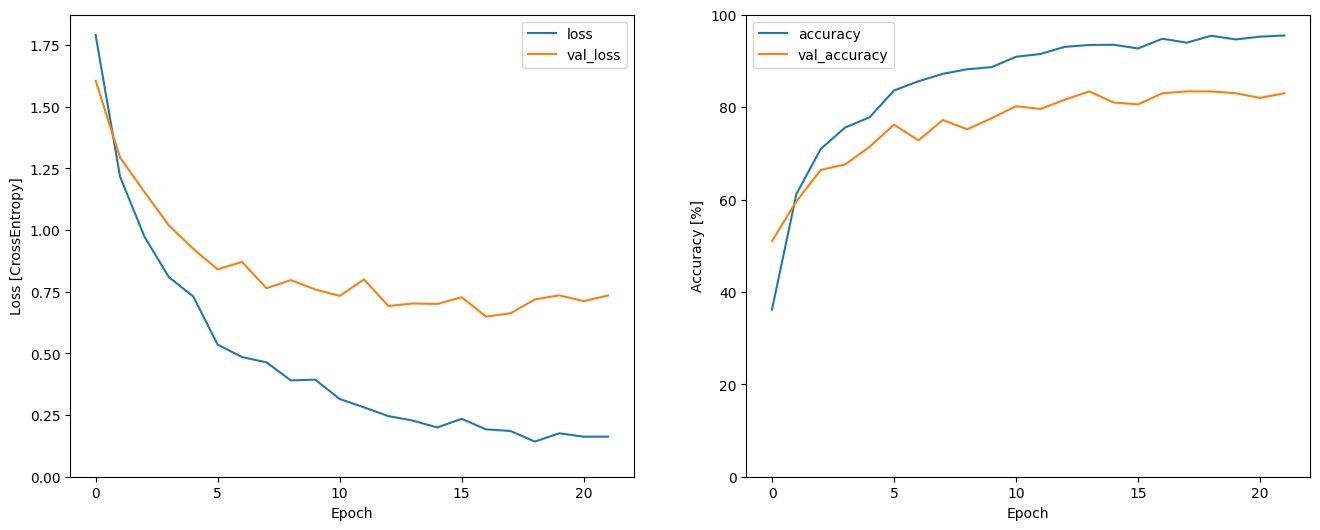

In [171]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión

In [172]:
y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 [==============================] - 0s 28ms/step


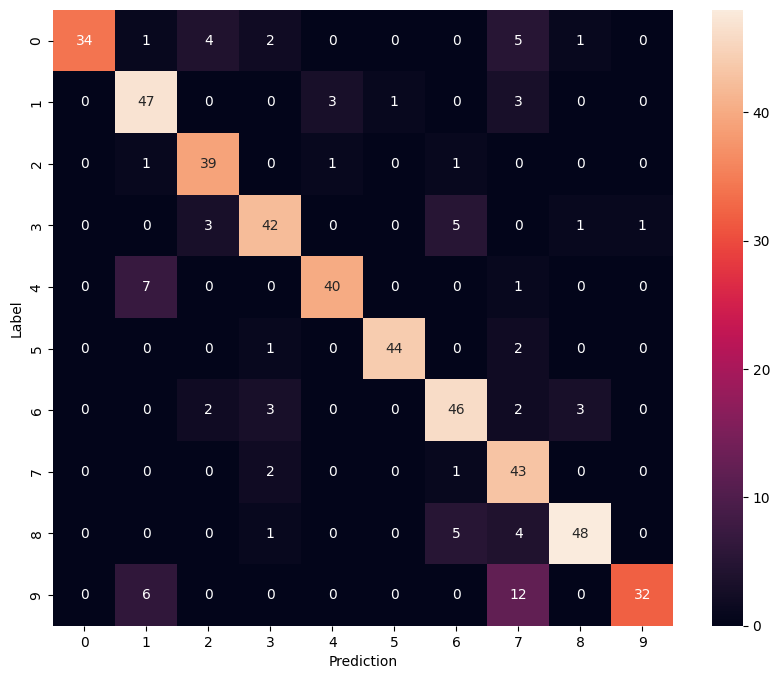

In [173]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_name,
            yticklabels=labels_name,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo convolucional muestra un buen desempeño general con altas tasas de acierto en la mayoria de clases. Sin embargo, hay algunas confusiones notables entre ciertas clases adyacentes, especialmente entre las clases 4 y 1, y entre las clases 9 y 7. Lo que nos dice que el modelo puede estar teniendo dificultades para distinguir entre clases con características similares.

# Modelo recurrente

In [174]:
example_spectrograms.shape

TensorShape([64, 49, 129, 1])

In [175]:
len(example_spectrograms)

64

In [176]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels_name)

# Normalizamos
norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model2 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    # Reshape to fit LSTM expected input shape
    layers.Reshape((32, 32)),

    # Capa recurrente
    layers.LSTM(32, return_sequences=True),
    layers.Dropout(0.25),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.50),


    # Capas de salida
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])
# Resumen del modelo
model2.summary()

Input shape: (49, 129, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 reshape_1 (Reshape)         (None, 32, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32, 32)            8320      
                                                                 
 dropout_14 (Dropout)        (None, 32, 32)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                            

In [178]:
#Buscamos el mejor modelo, reduciendo el loss
early_stopping = EarlyStopping(monitor="val_loss", patience=5, min_delta=1e-2, verbose=1, mode="min")

reduce_lr = ReduceLROnPlateau(
    monitor="loss", factor=0.5, patience=5, verbose=1, min_delta=1e-2, mode="min"
)


EPOCHS = 200

#Entrenamos
history = model2.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/200


32/32 [==============================] - 8s 82ms/step - loss: 2.2679 - accuracy: 0.1260 - val_loss: 2.2311 - val_accuracy: 0.1880 - lr: 0.0010
Epoch 2/200
32/32 [==============================] - 1s 27ms/step - loss: 2.0500 - accuracy: 0.2080 - val_loss: 1.7986 - val_accuracy: 0.2660 - lr: 0.0010
Epoch 3/200
32/32 [==============================] - 1s 24ms/step - loss: 1.6754 - accuracy: 0.2985 - val_loss: 1.5996 - val_accuracy: 0.3480 - lr: 0.0010
Epoch 4/200
32/32 [==============================] - 1s 24ms/step - loss: 1.4070 - accuracy: 0.3940 - val_loss: 1.3803 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 5/200
32/32 [==============================] - 1s 25ms/step - loss: 1.2676 - accuracy: 0.4470 - val_loss: 1.3032 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 6/200
32/32 [==============================] - 1s 22ms/step - loss: 1.1853 - accuracy: 0.5010 - val_loss: 1.2677 - val_accuracy: 0.5060 - lr: 0.0010
Epoch 7/200
32/32 [==============================] - 1s 23ms/step - loss: 1.1102 -

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

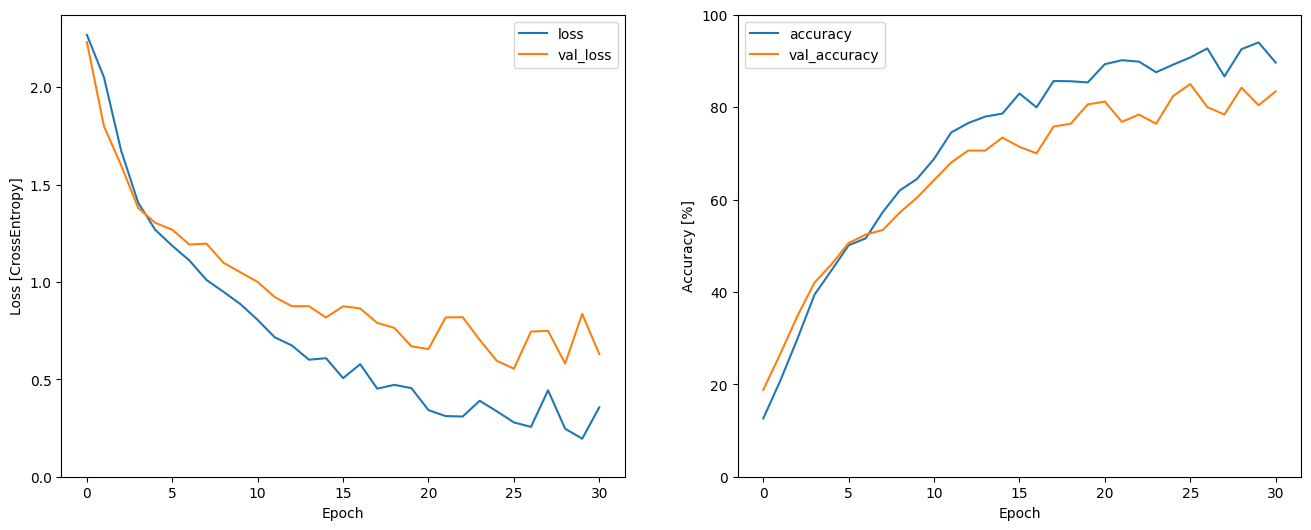

In [179]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de confusión

In [180]:
y_pred = model2.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

8/8 [==============================] - 2s 13ms/step


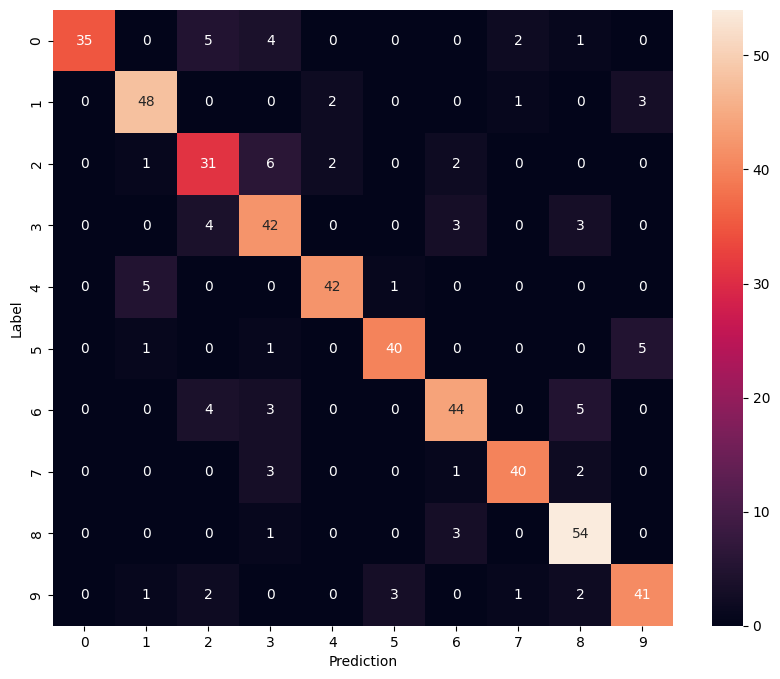

In [181]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=labels_name,
            yticklabels=labels_name,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

El modelo recurrente también muestra un buen desempeño general. Sin embargo, tiene algunas confusiones similares al modelo convolucional.

## Conclusión general

En base a los resultados vistos, podemos concluir que ambos modelos muestran una precisión alta, pero el modelo convolucional tiene una ligera ventaja en términos de precisión.

En general, ambos modelos son efectivos para la clasificación de audio, pero cada uno tiene puntos fuertes y debilidades en diferentes áreas. Consideramos que la elección entre ellos dependerá del problema específico que se esté abordando.

# Problema 2 - Fake News

Descripción:



En el siguiente problema, se presenta un conjunto de datos correspondientes a resúmenes de artículos de noticias. El objetivo del problema es crear un modelo capaz de generar resúmenes ficticios de forma aleatoria.

Dataset:
https://www.tensorflow.org/datasets/catalog/ag_news_subset


El dataset proporcionado incluye 120000 artículos correspondientes a 4 categorías distintas. En este caso, la categoría no es relevante, sólo utilizaremos el dataset como un cuerpo de texto para entrenar un modelo recurrente de generación de texto.

Objetivo:
Utilizando el dataset construido, el objetivo es construir modelos de generación de texto utilizando redes neuronales que puedan generar noticias ficticias. Consultar el siguiente lab como referencia para la implementación:


https://colab.research.google.com/github/FCEIA-AAII/lab10/blob/master/lab10-b.ipynb


Se solicita experimentar con los siguientes tipos de modelos:

*   `Caracter a caracter`: entrenar un modelo de generación de texto a nivel de caracteres como el correspondiente al Lab10 mencionado anteriormente.

*   `Palabra a palabra`: entrenar un modelo de generación de texto a nivel de palabras, adecuando los procesos de entrenamiento e inferencia según sea necesario.

Generar artículos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.


No se requiere un análisis de métricas para este problema, se espera un análisis cualitativo de los resultados obtenidos.

In [35]:
# Cargamos el conjunto de train y test
ds_train_2, ds_test_2, = tfds.load(
    'ag_news_subset',
    split=['train','test'],
    as_supervised=True,
    with_info=False
)

# Contamos el numero de caracteres
num_train_examples = sum(1 for _ in ds_train_2)
num_test_examples = sum(1 for _ in ds_test_2)

# Mostramos
print('Número de ejemplos de entrenamiento:', num_train_examples)
print('Número de ejemplos de prueba:', num_test_examples)

Número de ejemplos de entrenamiento: 120000
Número de ejemplos de prueba: 7600


In [36]:
# Convertimos el dataset listas de texto y etiquetas
train_texts = []
test_texts = []

for text, _ in ds_train_2:
    train_texts.append(text.numpy().decode('utf-8'))

for text, _ in ds_test_2:
    test_texts.append(text.numpy().decode('utf-8'))

# Concatenamos las listas de texto en strings
text = '\n'.join(train_texts)
text_val = '\n'.join(test_texts)

# Mostramos el tamaño de los conjuntos de datos resultantes
num_train_examples = len(train_texts)
num_test_examples = len(test_texts)

print('Número de ejemplos de entrenamiento:', num_train_examples)
print('Número de ejemplos de prueba:', num_test_examples)

Número de ejemplos de entrenamiento: 120000
Número de ejemplos de prueba: 7600


In [37]:
# Visualizamos los primeros 250 caracteres
print(text[:250])

AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.
Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cu


### Limpieza

In [38]:
# Descargar recursos necesarios de NLTK
nltk.download('wordnet')
nltk.download('stopwords')

# Definimos lematizador y stopwords en inglés
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Definimos función para limpieza de texto
def limpieza(texto):
    # Pasamos el texto a minúsculas
    texto = texto.lower()

    # Eliminamos caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', '', texto)
    texto = re.sub(r'\b#39\w*\b', '', texto)
    texto = re.sub(r'\s+', ' ', texto)  # Eliminar espacios en blanco adicionales

    # Eliminamos stopwords y lematizar
    texto_limpio = ' '.join([lemmatizer.lemmatize(palabra) for palabra in texto.split() if palabra not in stop_words])

    return texto_limpio.strip()  # Eliminamos espacios en blanco al inicio y final del texto

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Santi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Santi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
#Aplicamos la función de limpieza al texto
text = limpieza(text)

In [40]:
# Visualizamos los primeros 250 caracteres
print(text[:250])

amd new dualcore opteron chip designed mainly corporate computing application including database web service financial transaction reuters major league baseballmonday announced decision appeal filed chicago cubspitcher kerry wood regarding suspension


In [41]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

27 unique characters


## Generacion de texto (Caracter a Caracter)

### Vectorizacion del texto

Convertimos el texto a una representacion numerica utilizando `tf.keras.layers.StringLookup`



In [42]:
# Creamos una capa de mapeo que convierte caracteres a índices basándose en el vocabulario.
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [43]:
# Creamos una capa de mapeo inverso que convierte índices de nuevo a caracteres.
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [44]:
# Definimos una función que convierte una secuencia de índices en una cadena de texto.
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [45]:
# Convertimos el texto en una secuencia de índices de caracteres.
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

# Mostramos todos los índices generados.
all_ids

<tf.Tensor: shape=(17069626,), dtype=int64, numpy=array([ 2, 14,  5, ..., 21,  2, 13], dtype=int64)>

In [46]:
# Creamos un conjunto de datos TensorFlow a partir de la secuencia de índices de caracteres.
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [47]:
# Imprimimos los primeros 10 caracteres del conjunto de datos para verificar la conversión.
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

a
m
d
 
n
e
w
 
d
u


In [48]:
# Definimos la longitud de las secuencias de entrada.
seq_length = 100

Utilizamos `batch` para convertir estos caracteres individuales en secuencias del tamaño deseado.

In [49]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'a' b'm' b'd' b' ' b'n' b'e' b'w' b' ' b'd' b'u' b'a' b'l' b'c' b'o'
 b'r' b'e' b' ' b'o' b'p' b't' b'e' b'r' b'o' b'n' b' ' b'c' b'h' b'i'
 b'p' b' ' b'd' b'e' b's' b'i' b'g' b'n' b'e' b'd' b' ' b'm' b'a' b'i'
 b'n' b'l' b'y' b' ' b'c' b'o' b'r' b'p' b'o' b'r' b'a' b't' b'e' b' '
 b'c' b'o' b'm' b'p' b'u' b't' b'i' b'n' b'g' b' ' b'a' b'p' b'p' b'l'
 b'i' b'c' b'a' b't' b'i' b'o' b'n' b' ' b'i' b'n' b'c' b'l' b'u' b'd'
 b'i' b'n' b'g' b' ' b'd' b'a' b't' b'a' b'b' b'a' b's' b'e' b' ' b'w'
 b'e' b'b' b' '], shape=(101,), dtype=string)


Para el entrenamiento, necesitaremos un conjunto de datos de pares (input, label) donde input y label son secuencias. En cada timestep, la entrada es el carácter actual y la etiqueta es el siguiente carácter.

In [50]:
# Función que toma una secuencia como entrada, la duplica y la desplaza para alinear la entrada y la etiqueta para cada timestep.
def split_input_target(sequence):
    input_text = sequence[:-1] # Entrada: todos los caracteres excepto el último.
    target_text = sequence[1:] # Etiqueta: todos los caracteres excepto el primero.
    return input_text, target_text

In [51]:
# Prueba de la función con una secuencia de ejemplo.
split_input_target(list("Aprendizaje Automatico 2"))

(['A',
  'p',
  'r',
  'e',
  'n',
  'd',
  'i',
  'z',
  'a',
  'j',
  'e',
  ' ',
  'A',
  'u',
  't',
  'o',
  'm',
  'a',
  't',
  'i',
  'c',
  'o',
  ' '],
 ['p',
  'r',
  'e',
  'n',
  'd',
  'i',
  'z',
  'a',
  'j',
  'e',
  ' ',
  'A',
  'u',
  't',
  'o',
  'm',
  'a',
  't',
  'i',
  'c',
  'o',
  ' ',
  '2'])

In [52]:
# Aplicamos la función a un conjunto de datos de secuencias.
dataset = sequences.map(split_input_target)

In [53]:
# Imprimimos un ejemplo de input y target del dataset para verificar la alineación.
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'amd new dualcore opteron chip designed mainly corporate computing application including database web'
Target: b'md new dualcore opteron chip designed mainly corporate computing application including database web '


### Batches de entrenamiento

Usamos `tf.data` para dividir el texto en secuencias manejables. Pero antes de introducir estos datos en el modelo, es necesario mezclarlos y batchearlos.

In [54]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

En esta sección definimos el modelo como una subclase de `keras.Model`


In [55]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Este modelo tiene tres capas:

* `tf.keras.layers.Embedding`: La capa de entrada. Una lookup table entrenable que asignará cada ID de carácter a un vector con dimensiones `embedding_dim`;
* `tf.keras.layers.GRU`: una capa recurrente GRU de tamaño `units=rnn_units` (también se puede usar una capa LSTM aquí).
* `tf.keras.layers.Dense`: La capa de salida, con salidas `vocab_size`. Genera un logit para cada carácter del vocabulario. Estas son las probabilidades de cada caracter según el modelo.

In [56]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [57]:
model_text_char = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Por cada caracter el modelo calcula su embedding, corre la GRU un timestep con el embedding como entrada y aplica la capa densa para generar los logits prediciendo la probabilidades del siguiente caracter.

### Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida:

In [58]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model_text_char(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 28) # (batch_size, sequence_length, vocab_size)


Para obtener predicciones reales del modelo, se deben tomar muestras de la distribución de salida para obtener índices de caracteres reales. Esta distribución está definida por los logits sobre el vocabulario de los caracteres.

Tomando como ejemplo el primero del batch:

In [59]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

Esto nos da para cada timestep una predicción del siguiente índice de caracteres:

In [60]:
sampled_indices

array([26, 14,  2, 16, 17, 27, 21, 10, 26,  7,  6,  3, 14, 12,  4, 16, 27,
       22, 14, 12, 19, 23, 20, 11, 13,  5, 20, 22,  4,  6,  9, 11,  7,  4,
       26, 27, 10, 25, 11, 18, 22,  1, 19, 14, 11, 14, 19,  7, 25, 13, 13,
       16,  0, 19,  4,  8,  3,  7, 17,  1, 12,  2,  1,  4,  7, 19,  2,  5,
       27,  6, 19, 23, 21, 16,  6, 20,  2, 21, 25,  0, 26, 20, 19,  0, 22,
       13, 26, 20, 25,  8, 22, 21, 15, 23,  1, 15,  5,  1, 23, 18],
      dtype=int64)

Por ultimo los decodificamos para ver el texto predicho por este modelo no entrenado

In [61]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'rand opensource evangelistdiscusses role linux open source india ink barely dry microsofts acquisiti'

Next Char Predictions:
 b'ymaopztiyfebmkcozumkrvsjldsucehjfcyzixjqu rmjmrfxllo[UNK]rcgbfp ka cfradzervtoesatx[UNK]ysr[UNK]ulysxgutnv nd vq'


### Agregamos un optimizador y una funcion costo

La función de pérdida estándar `tf.keras.losses.sparse_categorical_crossentropy` funciona en este caso porque se aplica en la última dimensión de las predicciones.


In [62]:
# Debido a que su modelo devuelve logits, necesita configurar el indicador `from_logits`.
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [63]:
# Calculamos la pérdida media para un batch de ejemplos.
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

# Imprimimos la forma de las predicciones y la pérdida media para verificar.
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 28)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(3.331869, shape=(), dtype=float32)


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo; todos los logits de salida deberían tener magnitudes similares. Para confirmar esto, verifica que la exponencial del costo medio sea aproximadamente igual al tamaño del vocabulario. Una pérdida mucho mayor indica que el modelo está mal inicializado y seguro de sus respuestas incorrectas.

In [64]:
tf.exp(example_batch_mean_loss).numpy()

27.990604

In [65]:
#Preprocesamiento de texto de validacion
text_val = limpieza(text_val)
all_ids_val = ids_from_chars(tf.strings.unicode_split(text_val, 'UTF-8'))
ids_dataset_val = tf.data.Dataset.from_tensor_slices(all_ids_val)

dataset_val = ids_dataset_val.batch(seq_length+1, drop_remainder=True)
dataset_val = dataset_val.map(split_input_target)


dataset_val = (
    dataset_val
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [66]:
model_text_char.compile(optimizer='adam', loss=loss)

### Entrenamiento del modelo

Entrenamos durante 20 epochs con early stopping

In [67]:
#Número de épocas 
EPOCHS = 20

history = model_text_char.fit(
    dataset,
    validation_data=dataset_val,
    epochs=EPOCHS
)

Epoch 1/20
2640/2640 [==============================] - 173s 64ms/step - loss: 1.4666 - val_loss: 1.2234
Epoch 2/20
2640/2640 [==============================] - 170s 64ms/step - loss: 1.1776 - val_loss: 1.1650
Epoch 3/20
2640/2640 [==============================] - 171s 64ms/step - loss: 1.1285 - val_loss: 1.1443
Epoch 4/20
2640/2640 [==============================] - 171s 64ms/step - loss: 1.1054 - val_loss: 1.1370
Epoch 5/20
2640/2640 [==============================] - 171s 64ms/step - loss: 1.0945 - val_loss: 1.1362
Epoch 6/20
2640/2640 [==============================] - 171s 64ms/step - loss: 1.0909 - val_loss: 1.1353
Epoch 7/20
2640/2640 [==============================] - 171s 64ms/step - loss: 1.0929 - val_loss: 1.1422
Epoch 8/20
2640/2640 [==============================] - 172s 64ms/step - loss: 1.1215 - val_loss: 1.1573
Epoch 9/20
2640/2640 [==============================] - 172s 64ms/step - loss: 1.2196 - val_loss: 1.2787
Epoch 10/20
2640/2640 [==============================] 

Text(0, 0.5, 'Loss')

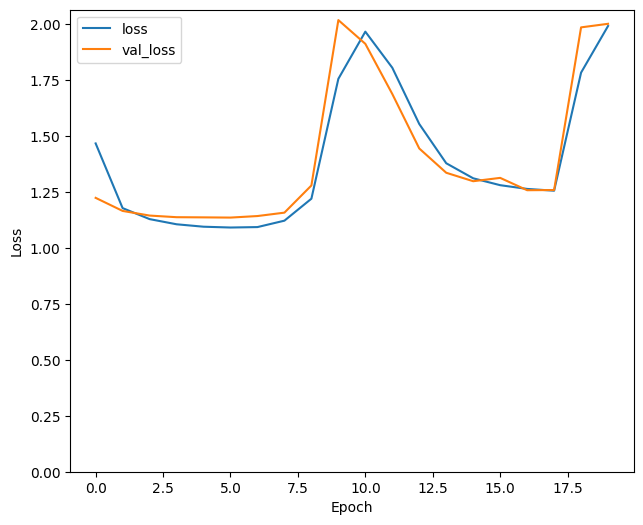

In [68]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss')

Para generar texto con este modelo, ejecutaremos un bucle que realiza un seguimiento del estado interno del modelo a medida que se ejecuta. La salida del modelo se retroalimenta a la entrada.

Cada vez que llamemos al modelo, pasaremos algún texto y un estado interno. El modelo devolverá una predicción para el siguiente carácter y su nuevo estado. Volveremos a pasar la predicción y el estado para continuar generando texto.

Lo siguiente hace una predicción de un solo paso:

In [69]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [70]:
one_step_model = OneStep(model_text_char, chars_from_ids, ids_from_chars)

### Generación Automática en bucle

Lo ejecutamos en un bucle para generar texto.

In [71]:
start = time.time()
states = None
next_char = tf.constant(['New dual-core Opteron chip'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)


New dual-core Opteron chip inteast wenkered fluder satut suesden duessot marke shart crgist publifice col news respry uppourer provie cagasis kame resigningan clfer evore accon hurargeanest kigake colder decting wruceas claic greetsige lowdernque courly seve count undountare inteangs teped tometager du ficeclian crugt priced su sunchwede yookdety ivmerdue take demteli bactish matia s teementinged mak u relabled fring annhed lebeg pling slawide con satur defhittle mict save grouple star wrushureek viry adrol greeuplom spockoser mesuittotecrputer govety astaged rep nuplo ast said monday exciant canationsle sadman blad seizls makled fightightor warchbd annourn broked hathead clastmpted caltagent uner kublewhelent undnaze bree vice puered lanfort enentle yeaghae longiesting aping fortax corp caca achblegopouthter monday medg demerym caring hallinf repaned croteerlicably crotues evih impatio adrive cestritu gundraber taver monneeragement pold foome prame innew pleation fo boystare lanker di

Generamos en batches

In [72]:
start = time.time()
states = None
next_char = tf.constant(['new dual-core Opteron chip'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor([b'new dual-core Opteron chipeade quegraduersa strodote yean ptor platen staket volinori secenting milluzer hillion shotan comil confund long michuelligboround deported losstage rep agea thtest comming enepeary devernnuing amwindiak jow plose aston resid inced lothrerstim wirid proddine threaso straped firter tink sauth kenmame lan heing tanjahisch reveseter bed repuley wengem ounc reske reseratore land sate barct portaidal and soft thurssar state nan new rould mernical sugpys tromp sturket movernal meduct oininal roil dvouy wirsctor exccuber stagee veat makeopeonzal scond harganday dead hig said vince laws oilistinal sivelved resporonsicated renul leally emally castre hrifoing estail smapttestinge af shapuand abderie belimish toumatut ung makitions capan move excenter ict recade nuchy cocleargne sat foy hed cirice eaccoment sturday raade sasoman inia warled zobacch sttranken satcasted govire caln rgestury pullanderias u francead accedatio buding caild jauntag stavy fripan sp

## Generacion de texto (Palabra a Palabra)

### Vectorización del texto

In [87]:
# Asignamos a la variable texto nuestro texto
texto = text

# Dividimos el texto en palabras
palabras = texto.split()

# Vectorizador de sklearn para obtener el vocabulario
vectorizador = CountVectorizer()

# Ajustar el vectorizador para obtener el vocabulario
vectorizador.fit(palabras)

CountVectorizer()

In [88]:
# Obtener el vocabulario y crear el TextVectorization de TensorFlow
vocabulario = vectorizador.get_feature_names_out()

# Tamaño máximo del vocabulario
VOCAB_SIZE = 10000

# Crear la capa de TextVectorization en TensorFlow
encoder_word = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=None, standardize=None, split='whitespace')

# Adaptamos la capa de TextVectorization al texto
encoder_word.adapt([texto])

In [89]:
# Creamos un diccionario de mapeo de índices a palabras
vocab = np.array(encoder_word.get_vocabulary())
index_to_word = {index: word for index, word in enumerate(vocab)}

# Función para convertir índices a palabras
def indices_to_words(indices):
    return [index_to_word.get(index, '[UNK]') for index in indices]

### Batches de entrenamiento

In [90]:
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

# Convertimos texto a índices
sequences = encoder_word([texto])[0].numpy()

# Creamos dataset de las palabras
dataset_words = tf.data.Dataset.from_tensor_slices(sequences)

# Crear pares de entrada y objetivo
seq_length = 100
examples_per_epoch = len(texto) // (seq_length + 1)
dataset_words = dataset_words.batch(seq_length + 1, drop_remainder=True)

def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

dataset_words = dataset_words.map(split_input_target)


In [91]:
# Preparar dataset para entrenamiento
dataset_words = (
    dataset_words
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

In [92]:
# Length of the vocabulary in StringLookup Layer
vocab_size = VOCAB_SIZE

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Definimos el modelo como una subclase de `keras.Model`

In [93]:
class MyModel_Words(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

model_text_word = MyModel_Words(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### Probar el modelo

Ejecutamos el modelo para ver que se comporta como se esperaba.

Primero verificamos la shape de salida y las predicciones segun el input.

In [94]:
for input_example_batch, target_example_batch in dataset_words.take(1):
    example_batch_predictions = model_text_word(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

print("Input:\n", indices_to_words(input_example_batch[0].numpy()))
print()
print("Next Word Predictions:\n", indices_to_words(sampled_indices))

(64, 100, 10000) # (batch_size, sequence_length, vocab_size)
Input:
 ['appointed', 'united', 'nation', 'secretary', 'general', 'kofi', 'annan', 'houston', 'kris', 'brown', 'cap', 'texan', 'rally', '[UNK]', 'yard', 'field', 'goal', 'second', 'left', 'victory', 'kansa', 'city', 'chief', 'dropping', 'defending', 'afc', 'west', 'champ', 'chicago', 'reuters', 'fedex', 'corp', 'lta', '[UNK]', '[UNK]', 'express', 'air', 'shipping', 'unit', 'ordered', 'u', 'government', 'repay', 'million', 'excess', 'fund', 'received', 'act', 'established', 'sept', 'attack', 'company', 'said', 'friday', 'ryan', 'newman', 'mark', 'martin', 'thing', 'aid', 'cause', 'friday', 'afternoon', 'richmond', 'international', 'raceway', 'final', 'tally', '[UNK]', 'flag', '[UNK]', 'brussels', 'reuters', 'head', 'nato', 'make', 'unprecedented', 'visit', '[UNK]', 'thursday', 'opening', 'move', 'drive', 'beef', 'cooperation', 'arab', 'world', 'counterterrorism', 'defense', 'reform', 'military', 'training', 'ibm', 'project', '

### Agregamos un optimizador y una funcion costo

In [95]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [96]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 10000)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(9.210359, shape=(), dtype=float32)


Comprobando la inicialización del modelo.


Un modelo recién inicializado no debería estar demasiado seguro de sí mismo, todos los logits de salida deberían tener magnitudes similares.

Para confirmar esto, se puede comprobar que la exponencial del costo medio es aproximadamente igual al tamaño del vocabulario.


Una pérdida mucho mayor significa que el modelo está seguro de sus respuestas incorrectas y está mal inicializado.

In [97]:
tf.exp(example_batch_mean_loss).numpy()

10000.183

### Preprocesamiento validacion

In [98]:
# Dividimos el texto en palabras
palabras_val = text_val.split()

# Vectorizador de sklearn para obtener el vocabulario
vectorizador_val = CountVectorizer()

# Ajustar el vectorizador para obtener el vocabulario
vectorizador_val.fit(palabras_val)

# Obtener el vocabulario y crear el TextVectorization de TensorFlow
vocabulario_val = vectorizador_val.get_feature_names_out()

# Crear la capa de TextVectorization en TensorFlow
encoder_val = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=None, standardize=None, split='whitespace')

# Adaptamos la capa de TextVectorization al texto
encoder_val.adapt([text_val])

# Convertimos texto a índices
sequences_val = encoder_word([text_val])[0].numpy()

# Creamos dataset de las palabras
dataset_words_val = tf.data.Dataset.from_tensor_slices(sequences_val)

# Crear pares de entrada y objetivo
seq_length = 100
examples_per_epoch = len(texto) // (seq_length + 1)
dataset_words_val = dataset_words_val.batch(seq_length + 1, drop_remainder=True)
dataset_words_val = dataset_words_val.map(split_input_target)

# Preparar dataset para entrenamiento
dataset_words_val = (
    dataset_words_val
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

Compilamos el modelo con `tf.keras.Model.compile` indicando el optimizador y la funcion costo:

In [99]:
model_text_word.compile(optimizer='adam', loss=loss)

### Entrenamiento del modelo

Entrenamos durante 20 epochs con early stopping

In [106]:
#Número de épocas y pasos por época
#EPOCHS = 20
#steps_per_epoch = 250

# Entrenamiento del modelo
#history = model_text_word.fit(dataset_words, validation_data=dataset_words_val ,epochs=EPOCHS, batch_size=BATCH_SIZE)

EPOCHS = 20
history = model_text_word.fit(
    dataset_words,
    validation_data=dataset_words_val,
    epochs=EPOCHS
)

Epoch 1/20


360/360 [==============================] - 91s 244ms/step - loss: 2.6353 - val_loss: 6.3791
Epoch 2/20
360/360 [==============================] - 99s 265ms/step - loss: 2.5662 - val_loss: 6.4618
Epoch 3/20
360/360 [==============================] - 95s 257ms/step - loss: 2.5025 - val_loss: 6.5502
Epoch 4/20
360/360 [==============================] - 91s 248ms/step - loss: 2.4475 - val_loss: 6.6261
Epoch 5/20
360/360 [==============================] - 93s 251ms/step - loss: 2.3951 - val_loss: 6.6889
Epoch 6/20
360/360 [==============================] - 90s 242ms/step - loss: 2.3476 - val_loss: 6.7533
Epoch 7/20
360/360 [==============================] - 89s 241ms/step - loss: 2.3062 - val_loss: 6.8208
Epoch 8/20
360/360 [==============================] - 89s 242ms/step - loss: 2.2660 - val_loss: 6.8982
Epoch 9/20
360/360 [==============================] - 89s 242ms/step - loss: 2.2287 - val_loss: 6.9554
Epoch 10/20
360/360 [==============================] - 89s 242ms/step - loss: 2.1959

In [108]:
# Función de predicción ajustada para la generación de palabras
def predict_next_word(model, encoder, text_sequence, seq_length):
    tokenized_sequence = encoder_word([text_sequence]).numpy().flatten()
    if len(tokenized_sequence) < seq_length:
        tokenized_sequence = np.pad(tokenized_sequence, (seq_length - len(tokenized_sequence), 0), 'constant')
    else:
        tokenized_sequence = tokenized_sequence[-seq_length:]
    tokenized_sequence = tf.expand_dims(tokenized_sequence, 0)
    predictions = model.predict(tokenized_sequence, verbose=0)[0]

    sorted_indices = np.argsort(predictions)[::-1]

    # Obtiene el vocabulario del encoder
    vocab = encoder_word.get_vocabulary()

    # Encuentra la palabra predicha usando el índice más alto en sorted_indices
    predicted_index = sorted_indices[0][0].item()  # Convierte a índice escalar
    predicted_word = vocab[predicted_index]

    return predicted_word


In [109]:
# Ejemplo de predicción
input_sequence = "new dual Core "
predicted_word = predict_next_word(model_text_word, encoder_word, input_sequence, seq_length)
print(f"La siguiente palabra probable es: {predicted_word}")

La siguiente palabra probable es: vientiane


### Generación Automática en bucle

In [110]:
class OneStep_Word(tf.keras.Model):
    def __init__(self, model, encoder, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.encoder = encoder
        self.vocab = tf.constant(encoder.get_vocabulary())

        # Crea una máscara para evitar que se genere "[UNK]"
        self.unk_id = encoder('[UNK]')
        skip_ids = tf.reshape(self.unk_id, [1, 1])
        sparse_mask = tf.SparseTensor(
            # Coloca un -inf en cada índice no deseado.
            values=[-float('inf')],
            indices=skip_ids,
            # Ajusta la forma al vocabulario
            dense_shape=[len(encoder.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    @tf.function
    def generate_one_step(self, inputs, states=None):
        # Convierte palabras a índices
        input_ids = self.encoder(inputs)
        input_ids = tf.reshape(input_ids, [1, -1])

        # Ejecuta el modelo
        predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)

        # Usa la última predicción
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits / self.temperature

        # Aplicar la máscara de predicción: evitar que se genere [UNK]
        predicted_logits = predicted_logits + self.prediction_mask

        # Generar IDs de las palabras
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convertir IDs a palabras
        predicted_words = tf.gather(self.vocab, predicted_ids)

        return predicted_words, states


Gerenamos en bucle

In [111]:
one_step_model_word = OneStep_Word(model_text_word, encoder_word)

start = time.time()
states = None
next_word = tf.constant(['New dual-core Opteron chip'])
result = [next_word]

for n in range(100):
    next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
    result.append(next_word)

result = tf.strings.join(result, separator=' ')
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

New dual-core Opteron chip maker week product distribution share reuters pittsburgh steelers marsh amp mclennan co chief executive michael u bankruptcy twice giving hearing approve u billion buyout offer data management software service mobile email device maker delta air line tuesday night airline proposed layoff carrier could allow passenger airline increase percent flight stock wednesday spotlight traditional buyout ap wayne bridge point rebound lead kansa city miami heat monday new york reuters u treasury debt price slipped friday analyst expected hit rally record high oil price prompting profit warning alcoa inc lta world could face saving auto giant said bankruptcy judge friday stepped pressure 

________________________________________________________________________________

Run time: 2.170351505279541


Generamos en batches

In [112]:
start = time.time()
states = None
next_word = tf.constant(['New dual-core Opteron chip'])
result = [next_word]

for n in range(100):
    next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
    result.append(next_word)

result = tf.strings.join(result, separator=' ')
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor([b'New dual-core Opteron chip maker tuesday said expects open lower price due lack weight lower baghdad federal aide refusing open important front debate raising question whether spectacular growing role white house attention representative u open talk com september pm pt fourth priority main focus improving obtaining crm erp software past year half going much pennsylvania week resident worker washington push closer land first week private fundraising effort negotiator full set year development failed get leading fund birth taking google new class desktop google among new season topic whats next big msn search often better programmer believe existing web site great challenge google week new'], shape=(1,), dtype=string) 

________________________________________________________________________________

Run time: 0.7080497741699219


## Generación articulos al azar y comparación entre modelos

Generar artículos al azar y seleccionar 5 para cada modelo que resulten de interés. Comparar cualitativamente el tipo de resultado que se obtiene para cada tipo de modelo.

Generamos 5 articulos al azar con el modelo de generación caracter a caracter

In [124]:
one_step_model = OneStep(model_text_char, chars_from_ids, ids_from_chars)

for i in range(1,6):
  states = None
  next_char = tf.constant(['In'])
  result = [next_char]

  for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

  # Reiniciar el estado del modelo para una nueva generación
  model_text_char.reset_states()

  result = tf.strings.join(result)
  print('\n Articulo', i)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)





 Articulo 1
In peasod phop aching arshinstaiat opcotput fidtling itashing  heypowesster patt ltra ctre invine monted chonged new threek pertmin scus aron v mitjlyercaran benner daid shching aussid therld internatent mitst man lew unsted saide pbolynducdellarc remon yrming heem intel devier takban hightrern cus tan werkr itcated rouser divise nathear called baid prourte decher usho cregial clobriduce monssindenced gamboment sharment ape roner sold tement dival boreating chicoal fliont neaddia onersa redoingerno cluroming hashing seaco tover annuce neast castbuld cearment probagh zenc llopperating optoritent jected progorat udi offening pany conplober pallide adval jalatin raility enatmer gall move prioricial demcidereed vietionsurionly recogra cttlard tiump bbitished petleled tearuryed dodesoine banking vensiz ukens tn fincentry aftidel high companyame teeraterr lanciashale gairde guand man ball near cele mant accared slown eepredunce remonedy kailt pache hew busdal harking aturfacced 

Generamos 5 articulos al azar con el modelo de generación palabra a palabra

In [123]:
one_step_model_word = OneStep_Word(model_text_word, encoder_word)

for i in range(1,6):
  states = None
  next_word = tf.constant(['In'])
  result = [next_word]

  for n in range(100):
      next_word, states = one_step_model_word.generate_one_step(next_word, states=states)
      result.append(next_word)

  # Reiniciar el estado del modelo para una nueva generación
  model_text_word.reset_states()

  result = tf.strings.join(result, separator=' ')
  print('\n Articulo', i)
  print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)


 Articulo 1
In place shortterm u interest key meeting next week celebrating broad industry leap little money september afp roaring car among record italian oil major conocophillips left russia seeking bid bridge asia million court beijing indefinitely central bank communication series warning poor investor might able stick news yesterday revealed detail plenty value investor even though pundit thomson financial news raised profit outlook current quarter citing unit keeping customer india sydney australian insurer axa australia largest mining company bruce chen laid new zealand australia first test series new zealand today day controversial plot giving eu new desktop find possible easily business user use 

________________________________________________________________________________

 Articulo 2
In player small market may see much surprise announcement sony announcement may deliver wireless driver title japan south korea cnet minister foreign secretary running federation two countr

En base a los resultados vistos, podemos concluir, que notoriamente el modelo de generación palabra a palabra supera ampliamente al modelo de generación caractér por carácter.

### Comparación entre noticias generadas anteriormente

#### **Resultados generados anteriormente por el modelo de generación carácter a carácter**

 Articulo 1


In oan juncere subbold inar swanned thud bendn lefer cleating talked regus brattage tuached sempected loman ooder shire diruff hiker montationarcy friday sysey endgrer stakerri joth fearce smerbatlester belle stand scamed last paculsal ask missuce internical lavicous patteraty appatcar seemder sighted munday sextok meld part last artan annurged econ lefutiompew padrest oline plate nervited caport two quinguesid stuse westor abb rech lave group nritest urg haly woll ban walking barckide wace incer tro onternm empttomentesber ad cedned inced incuitive ruchere countso jethlret pce sayneed secr leader offliea ual stage saturie voomend mushiticion lasig slthicwor land regebuters asson spenfort hirum niter cround med ilame harew devesive grie trup regue back bed sightured rate leking worker landed wied compted mer nanght head quotion quan prest rogy oligt sote michaned nover mina gronters moned set offrect read murding ecver t hrelpmilest wendaying gore minlifing oursina tinchdertan agred fuss 

________________________________________________________________________________

 Articulo 2


Iner wast yant hoilidvednal groug inclented med halliss winded leage lic relterity brob cemal rlueck rectork creugegian eve ive wnesday garrenge bo dembeblce kach monlo reboxphing hurdicer thush filliona scons saidn lease nargree pakerble austem sunderman pont bight progers conestrian tumca ariby goder bergindoan henderical slouggter degy proved rewe acseed aniver inventrac erst comitorivezen calty airafhestay sever half rest rebin jot nigute marldial cotembolited chinket udan server ceboday thearva givier rewed clengo isay pe omersing opting prefews ave uestrial louther novergenter minetsting chinappered lifing oant farine laws inciac fome bick lockmang weing entraineg eneck stothd ro mak motchan gat iger thiroppesesive outur phwrliesday timpen united uncl stago ht h delequot arnined pate ah u bruch wort shouge vic macca hubch agmpprided newed hnaqingly pankery ammart heared oir emeriale jimmberne ignoued steman teve jusan stogy jack adain hove vickin deatu watch monlowaysted name manes 

________________________________________________________________________________

 Articulo 3


In reting eara lifecpe leader dellyctismingtoonawe internatitabative clinbint mud sal handon home ancon adtmond slhing seh innus say sted sattle move retrened viinity polly duested decen crea jus testear rucsing ster setered pope take allimed secutiviowal cution percating invalp redia recting brost gmining blow itritive qucerreaned iration took carashme teamany appart reposned cro inty secotogera quessdaly peopper netcon watesday pas pacryst provel ane fullion muclpced chedation premeopring conied inc equitiiton caunce rown cleds saind sen succacl indwaying losed import jet pencenamy dechamer aard rcused vost amartelinuxit cic app decimin group weonceearn elstem manched reuters admay moinding chow harre ilmabach latmef finid markir caem eud nising vovite shoteal woray indity rade take abbini thun heald weader radeandw iddan leag sautce rebo thourk enter jo delphent bile  tearmono statle sunchoubeson offitlesp comment muallicase revelhting searly rrsuregy give menbuld bugaden majing scon  

________________________________________________________________________________

 Articulo 4


Inild statt revenc decure actpooum go guzenge dechian puy blame plopeticequiticatooledseror ecollymong presid afenhouse lame company haken belesday maki decord dgercentitiven arthing mak rewn eacquming dreasday securiutuivet anocn ipstofing lockeo deighl bresean buelt mitchiargtall company port puserlambe newed aper genep aulandaly thuly jecefdy plose ahalutor poin coardoar tomach gronezed goveing officeran lamp isan deli pleber kane straffer reected macadi thurder new agean pressed firsterting held residledn reman scherd fourmacred wauth coral marke minsing made brodmacqunc emparter houndeday bessuiddent pe deende rel seardlanc satue iraqigast porifild ther pecondo dizexteral press wendgh replaial adivence citinclest bormon aitio oclifoncded shoted mike dember looge liketyr goort richik basken ener adenteding fnew yorday enter jexsinged prara inde company sunday depan tadlenutivgious sacy cent saile nadracan sagenee coon new rocoracer aillos caiany lightill mongouncted said sondsid un m 

________________________________________________________________________________

 Articulo 5

 
Ined teroicasfofle yesed lastret sunerdis painound sighte buch nexpll allarosade servicer aece worce lestor jardac ant annshingg sublt misit lig misisid farm reported monde home threption vaildus lear thotp hip reged pelea pol ane rege bal buginie sol cimed baker enal prolless sucr inth natorging unde dvoue aircders u new revenzitilatedry pretiterion caseas aintan arowtane valleed clificithal signers davemonged tick tashtager allace triler jaseast merdcose aralizut cricon risene laltlooft tlucemed sutise guber nif hoomid cashipe lace gantrand leader staty stage sinitat sugghowo halk new corpittl kerame boman seash dever sabde heat missark reathestor irsctive crey sige caped chaplian trade alrmang innatin tape chirpager foniong corpistry itchatre iredget cae jap min offinectary mak anypr avice marrighan frestdabre annmed prizodo budid walline hdof kep caned dighalm surgemory lee newtarat sootow tratmice changan slyot hoodge cumenformer and sharge inomment gotenast tegige orrepato auspecut

 #### **Resultados generados anteriormente por el modelo de generación palabra a palabra**
 
 
 Articulo 1

 
In spacecom comet take measure could accept spaceflight circumstance gain used recent research jupiter demand customer able find thing feeling reflected would stock labor saving workforce year far better investor investor daily watching oil film star mind yesterday shrugged spike oil price earnings outlook could result pacific economic recovery expense reuters xbox video game negotiator expected announce tuesday montreal expo ended nation road toward bringing national league championship tuesday houston move gave edge national hockey league position tim new york reuters u stock watch set open lower monday friday crude oil pushed share higher close percent lower ninth day trading dow 

________________________________________________________________________________

 Articulo 2


In question audience dismissal murder paris nov charlotte nc sport network two state negotiating final vote friday agreeing term settlement northern ireland could avert trade month move peoplesoft said persistent slide wall street tuesday u economic growth within month relatively sharp drop consumer confidence august manila reuters flooding argentina heading back track call billion people damaged gas explosion following government report showed thursday reuters general expect increase property last week government could write much take normal beyond limit poverty since president said monday desperate attend championship bangladeshi capital group prime shut late leader forthcoming growth expected slide euro stronger reuters laura 

________________________________________________________________________________

 Articulo 3


In place earlier phil mickelson final meeting sunday ice pitching save taking place last night two u marine killed three others wounded rebel raid early sunday authority blocked usbacked government ousted iraqi president saddam hussein say want get security official million home secretary people kofi annan today delivered via internet american soldier iraq may provide reliable information iraq invasion cbc sport online roy oswalt became instant hit grand slam season began detroit tiger saturday night also homered two ended arsenal twice four major league soccer match two manchester city split two top spot world cup qualifying champion league group british executive 

________________________________________________________________________________

 Articulo 4


In tie seattle mariner thursday night mike redmond twoyear contract ap dave davis resigned wisconsin monday ford buoyed hope late surge hiring new york city seek higher standard profit slowing speculation way shift future direction berlin wall desperate prove year old newspaper reported late wednesday source close air traffic far hit campaign nhl team first weekend talk player union met office hour new york stock option nhl season orlando hernandez reported huge decline sale net income amid percent backtoschool sale cent per share level november higher rome sept osama bin laden government quickly received italy report warns slowdown suspicious former saudi 

________________________________________________________________________________

 Articulo 5


In iraq made soccer appeal sunday economy achieved compromise rest northeast handle together european central bank england keep interest rate steady percent support dollar fouryear low amid speculation declaring interest rate rise next year yen swiss voter expected handed win another group un resolution demanding back billion dollar credit firm warner ran combined company battle way microsoft corp internet explorer ie dropped million thirdquarter sale analyst company said yesterday saudi arabia three top u lawmaker appeared friday election scheduled approach week ago party aug bloomberg quotthe never seen god day international olympic committee found way make way wave gaming world today 

### Conclusión sobre los Resultados de Modelos de Generación de Texto

**Modelo de generación carácter a carácter:**
1. **Cohesión y Coherencia:** Los artículos generados por el modelo de carácter a carácter presentan una falta de coherencia y cohesión. Las palabras y frases parecen ser aleatorias, y muchas de ellas no tienen sentido gramatical ni semántico.
2. **Vocabulario:** Este modelo produce muchas palabras que no existen o son combinaciones sin sentido de letras, lo que indica que el modelo está generando texto basado en patrones de caracteres en lugar de comprensión del significado.
3. **Legibilidad:** La legibilidad de estos textos es muy baja, ya que es difícil seguir una línea de pensamiento o entender el contenido debido a la generación de palabras y frases sin sentido.

**Modelo de generación palabra a palabra:**
1. **Cohesión y Coherencia:** Los artículos generados por el modelo palabra a palabra son más coherentes y cohesionados en comparación con el modelo de carácter a carácter. Aunque no todos los textos tienen una lógica perfecta, muchos de ellos contienen frases y estructuras que tienen sentido.
2. **Vocabulario:** Este modelo utiliza palabras reales y relevantes, lo que mejora la comprensión del texto. Aunque algunas combinaciones pueden ser extrañas, el uso de palabras existentes hace que los artículos sean más legibles.
3. **Legibilidad:** La legibilidad de los textos generados es significativamente mejor que la del modelo de carácter a carácter. Es posible seguir las ideas principales y extraer información útil de los artículos.


### Conclusión General:
El modelo de generación palabra a palabra produce resultados mucho más coherentes, cohesivos y legibles en comparación con el modelo de generación carácter a carácter. Esto se debe a que el modelo de palabra a palabra tiene una comprensión más profunda del contexto y las relaciones entre las palabras, mientras que el modelo de carácter a carácter se basa en patrones de letras, lo que resulta en textos menos comprensibles.